In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

%matplotlib inline
%config inlineBackend.figure_format='retina'

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

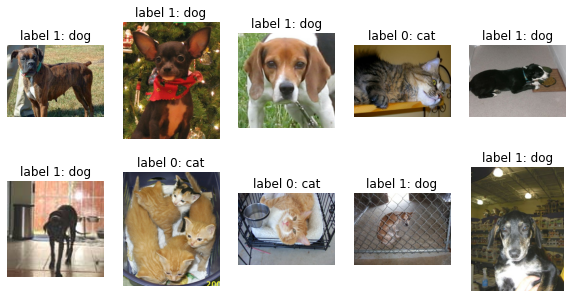

In [4]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [5]:
IMG_SIZE = 160

def format_example(image,label):
    image= tf.cast(image, tf.float32) #image=float(image)같은 타입캐스팅의 텐서플로우 버전
    image=(image/127.5)-1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label   

In [6]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

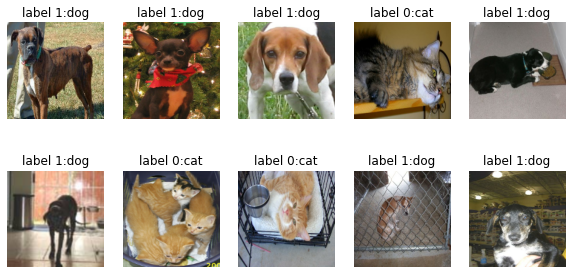

In [7]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image +1) / 2
    plt.imshow(image)
    plt.title(f'label {label}:{get_label_name(label)}')
    plt.axis('off')

In [8]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160,160,3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

In [10]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [12]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [13]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 0s 19ms/step - loss: 0.6951 - accuracy: 0.4844
initial loss: 0.70
initial accuracy: 0.48
